In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv("/content/drive/MyDrive/Programming/Machine learning/eqdatabase.csv")
data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [20]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


To make the data usable for our network, we're converting the date and time values into Unix timestamps. This changes them into a single number (seconds) that the model can accept as input.

In [21]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-157630542.0
1,1.863,127.352,80.0,5.8,-157465811.0
2,-20.579,-173.972,20.0,6.2,-157355642.0
3,-59.076,-23.557,15.0,5.8,-157093817.0
4,11.938,126.427,15.0,5.8,-157026430.0


In [43]:
# !pip install basemap basemap-data-hires

Before we build the earthquake prediction model, let's first plot the data on a world map. This visualization will help us clearly see which areas have the highest earthquake frequency.

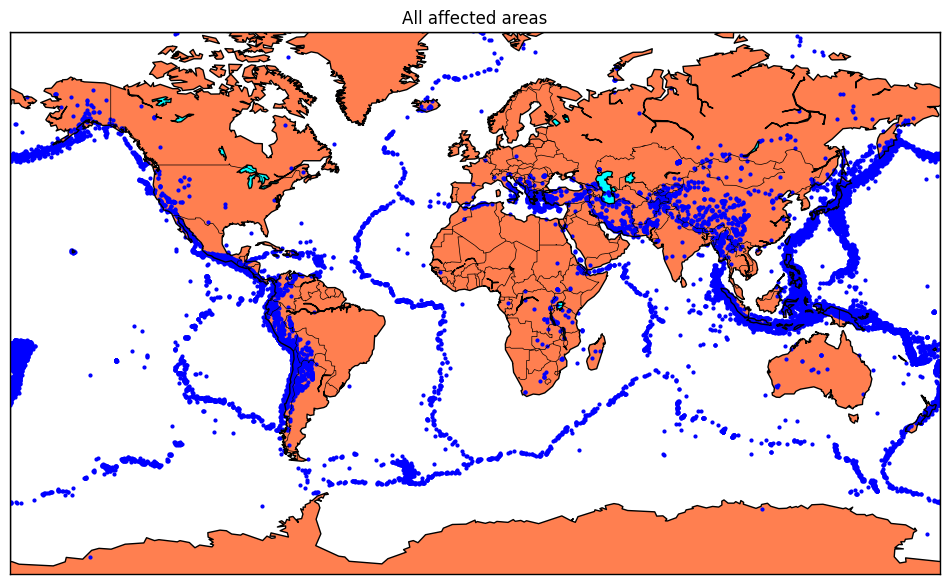

In [23]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

In [25]:
print(final_data.columns.tolist())


['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error', 'Depth Seismic Stations', 'Magnitude', 'Magnitude Type', 'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID', 'Source', 'Location Source', 'Magnitude Source', 'Status']


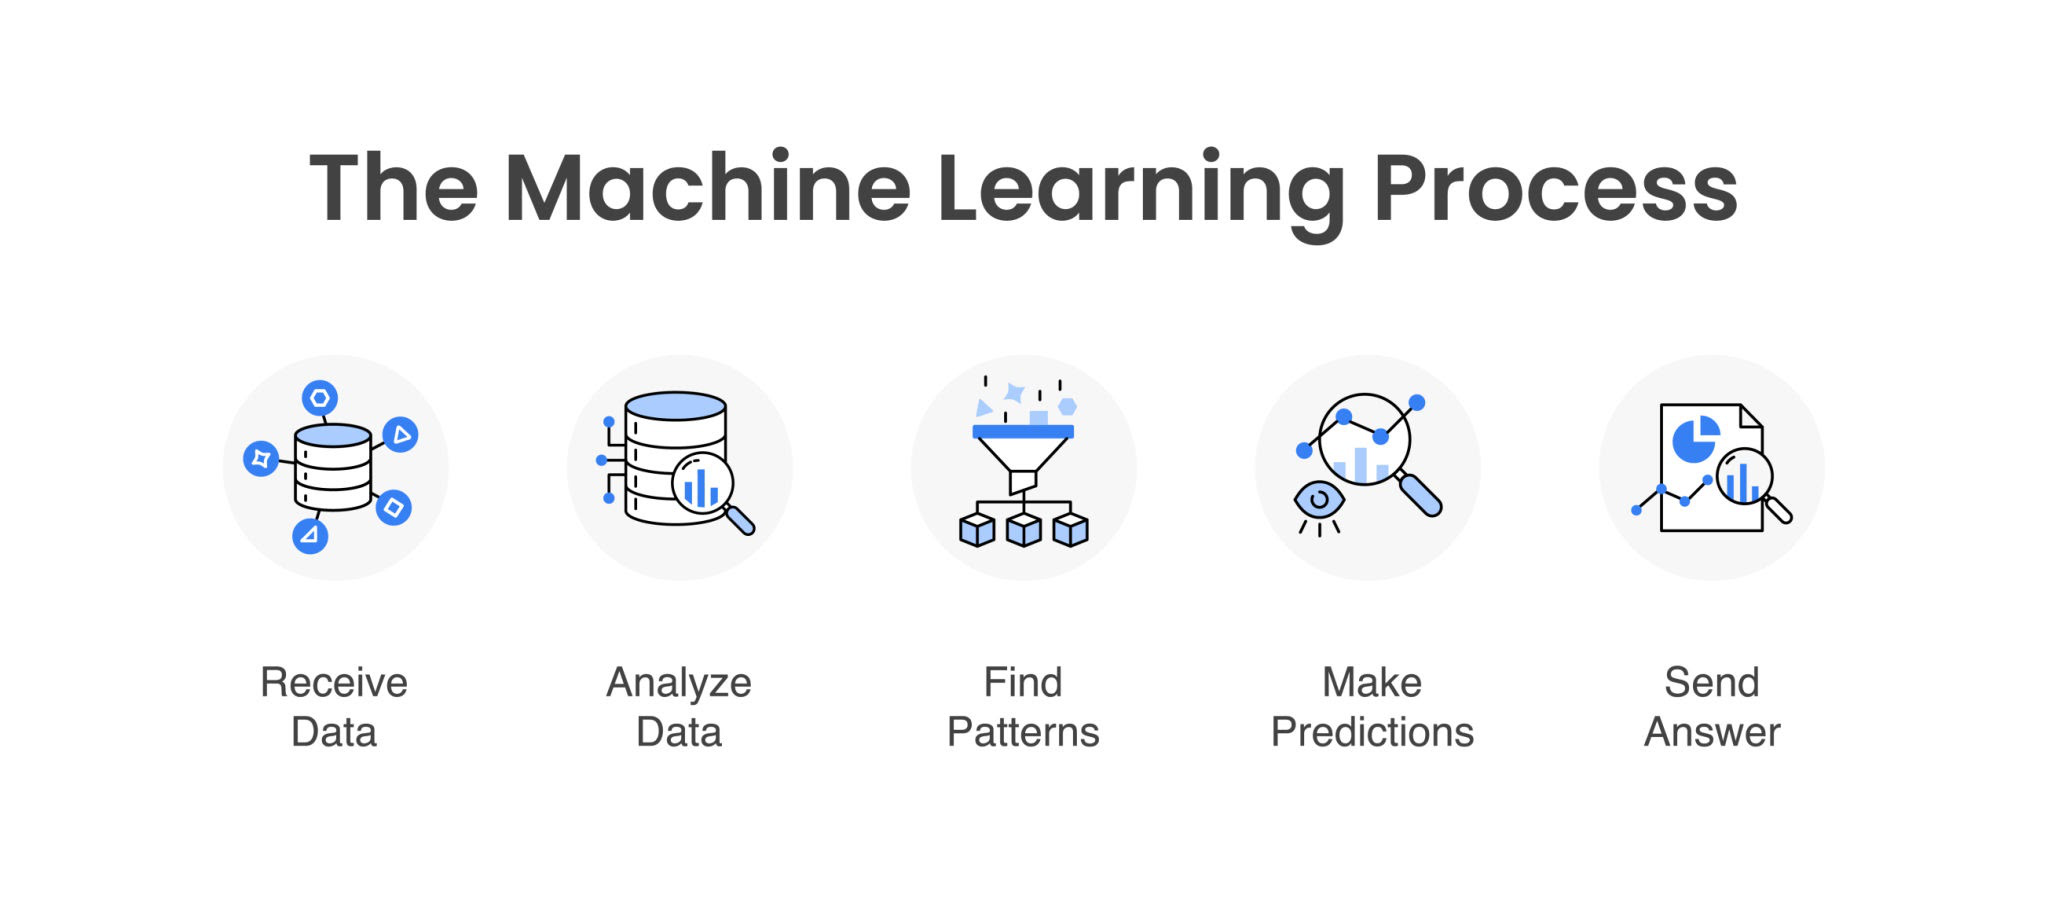

To train the earthquake prediction model, we must first separate the data into features ($\text{X}$) and targets ($\text{y}$).

- The features ($\text{X}$) (inputs) will be Timestamp, Latitude, and Longitude.
- The targets ($\text{y}$) (outputs) will be Magnitude and Depth.

We will then split this data into a training set (80%) for fitting the model and a test set (20%) for evaluating its performance, using validation during the process.

In [24]:
from sklearn.model_selection import train_test_split

# load your dataset
final_data = pd.read_csv("/content/drive/MyDrive/Programming/Machine learning/eqdatabase.csv")

# Select your input and output columns
X = final_data[['Time', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(18729, 3) (4683, 3) (18729, 2) (4683, 2)


In [34]:
#!pip install scikeras

**Neural Network for Earthquake Prediction**


---


Next, I will build a neural network model to train on the dataset. The network architecture includes three dense layers with 16, 16, and 2 neurons, respectively, using ReLU and Softmax as activation functions.

In [35]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [36]:
#!pip install -U scikit-learn scikeras

Define the hyperparameters for the model, providing at least two options for each so that we can use a systematic search (like Grid Search) to find the combination that yields the best performance.

In [37]:
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [39]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=create_model, activation='relu', verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(model__neurons=neurons, batch_size=batch_size, epochs=epochs, model__activation=activation, optimizer=optimizer, loss=loss)


We now need to execute the model search to find the combination of hyperparameters that gives the best performance.

Specifically, we will train the model using Grid Search, identify the configuration that provides the highest scoring "best fit," and then report its mean test score and standard deviation across the cross-validation folds.

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Using the best-fit parameters identified from the previous search, we will now train the final model and then calculate its performance score separately on both the training data (to check for overfitting) and the test data (to estimate generalization ability).

In [ ]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))